In [372]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import plplot
from scipy import stats
#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
from scipy.stats import gaussian_kde
from matplotlib import colors




0.24.2


In [373]:
def make_colourmap(ind, red, green, blue, name):
    newInd = range(0, 256)
    r = np.interp(newInd, ind, red, left=None, right=None)
    g = np.interp(newInd, ind, green, left=None, right=None)
    b = np.interp(newInd, ind, blue, left=None, right=None)
    colours = np.transpose(np.asarray((r, g, b)))
    fctab= colours/255.0
    cmap = colors.ListedColormap(fctab, name=name,N=None)
    return cmap

def get_califa_velocity_cmap():
    ind = [1., 35., 90.,125.,160.,220.,255.]
    red = [148., 0., 0., 55.,221.,255.,255.]
    green = [ 0., 0.,191., 55.,160., 0.,165.]
    blue = [211.,128.,255., 55.,221., 0., 0.]
    return make_colourmap(ind, red, green, blue, 'califa_vel')


def get_califa_velocity_cmap_2():
    ind = [0., 1., 35., 90.,125.,160.,220.,255.]
    red = [ 0.,148., 0., 0., 55.,221.,255.,255.]
    green = [ 0., 0., 0.,191., 55.,160., 0.,165.]
    blue = [ 0.,211.,128.,255., 55.,221., 0., 0.]
    return make_colourmap(ind, red, green, blue, 'califa_vel')

def get_califa_intensity_cmap_2():
    ind = [ 0., 1., 50.,100.,150.,200.,255.]
    red = [ 0., 0., 0.,255.,255., 55.,221.]
    green =	[ 0., 0.,191., 0.,165., 55.,160.]
    blue = [ 0.,128.,255., 0., 0., 55.,221.]
    return make_colourmap(ind, red, green, blue, 'califa_int')


def get_califa_intensity_cmap():
    ind = [ 1., 50.,100.,150.,200.,255.]
    red = [ 0., 0.,255.,255., 55.,221.]
    green =	[ 0.,191., 0.,165., 55.,160.]
    blue = [ 128.,255., 0., 0., 55.,221.]
    return make_colourmap(ind, red, green, blue, 'califa_int')

#califa_vel = get_califa_velocity_cmap()
#califa_int = get_califa_intensity_cmap()
#califa_int=cm.nipy_spectral
califa_int=cm.Spectral
califa_vel=cm.Spectral




def fit_leastsq_pure(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.01)
# epsfcn=0.0001)


    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, pcov 



In [374]:
def binning_OH(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    M_bin=[]
    OH_bin=[]
    D_OH_bin=[]
    
    OH_binM    = np.arange(min1,max1,bin1) 
    OH_binM = OH_binM-bin1*0.5
    m_range    = np.zeros(OH_binM.size)
    OH_binD    = np.zeros(OH_binM.size)

    for i, val  in enumerate(OH_binM):
        tmp = (OH_Ref_OK >= val) & (OH_Ref_OK <= val+bin1)
        m_sub=M_OK[tmp]
        n_vals=m_sub.size
        m_range[i]   = np.median(M_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])
        if (n_vals > 10):
            M_bin.append(m_range[i])
            OH_bin.append(OH_binM[i])
            D_OH_bin.append(OH_binD[i])
    m_range=np.array(M_bin)
    OH_binM=np.array(OH_bin)
    OH_binD=np.array(D_OH_bin)
        
    return(m_range, OH_binM, OH_binD)
    
def binning(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    
    m_range = np.arange(min1,max1,bin1)
    M_binM    = np.zeros(m_range.size)
    M_binV    = np.zeros(m_range.size)
    OH_binM    = np.zeros(m_range.size)
    OH_binD    = np.zeros(m_range.size)

    for i, val  in enumerate(m_range):
        tmp = (M_OK >= val) & (M_OK <= val+bin1)
        OH_binM[i]   = np.median(OH_Ref_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])+0.02
#        tmp = (OH_Ref_OK >= OH_binM[i]-0.125*OH_binD[i]) & (OH_Ref_OK <= OH_binM[i]+0.125*OH_binD[i]) & (M_OK >= val-4*bin1) & (M_OK <= val+5*bin1)       
        tmp = (OH_Ref_OK >= OH_binM[i]-0.1*OH_binD[i]) & (OH_Ref_OK <= OH_binM[i]+0.1*OH_binD[i]) & (M_OK >= val-3*bin1) & (M_OK <= val+3*bin1)       

        M_binM[i]   = np.median(M_OK[tmp])
        M_binV[i] = val+0.5*bin1        
        if ((np.isnan(M_binM[i])) or (np.isinf(M_binM[i]))):
            M_binM[i]=M_binV[i]
    M_bin_out=0.5*(M_binM+M_binV)
    #print '',M_binM,M_binV,M_bin_out
    return(M_bin_out, OH_binM, OH_binD)

def binning_old(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    
    m_range = np.arange(min1,max1,bin1)
    OH_binM    = np.zeros(m_range.size)
    OH_binD    = np.zeros(m_range.size)

    for i, val  in enumerate(m_range):
        tmp = (M_OK >= val) & (M_OK <= val+bin1)
        OH_binM[i]   = np.median(OH_Ref_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])
            
    return(m_range, OH_binM, OH_binD)

def make_cont(x ,y, min2s,max2s,min1s,max1s,bin1s,bin2s, frac):

    m1s      = math.floor((max1s-min1s)/bin1s) + 1
    m2s      = math.floor((max2s-min2s)/bin2s) + 1
    
    vals, xedges, yedges = np.histogram2d(x, y, bins=[m1s,m2s])
    
    xbins = 0.5 * (xedges[:-1] + xedges[1:])
    ybins = 0.5 * (yedges[:-1] + yedges[1:])
    
    L = (1-frac)*(np.max(vals) - np.min(vals))+ np.min(vals)
    return(xbins, ybins, vals.T, L)

def header_columns(filename,column):
    COMMENT_CHAR = '#'
    col_NAME = []
    with open(filename, 'r') as td:
        for line in td:
            if line[0] == COMMENT_CHAR:
                info = re.split(' +', line.rstrip('\n'))
                col_NAME.append(info[column])
    return col_NAME

In [375]:
get_proc_file="get_proc_elines_MaNGA.no_nan.csv"
col_NAME=header_columns(get_proc_file,2)
df_elines = pd.read_csv(get_proc_file,comment="#",names=col_NAME,sep=',',index_col=False)
df_elines.shape


/home/sanchez/.local/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


(8018, 540)

In [376]:
get_proc_file_ind="get_proc_indices_MaNGA.csv"
col_NAMES_ind=header_columns(get_proc_file_ind,2)
df_ind = pd.read_csv(get_proc_file_ind,comment="#",names=col_NAMES_ind,sep=',',index_col=False)
df_ind.shape
#print(df_ind.head(3))

/home/sanchez/.local/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


(8017, 27)

In [377]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

dataframe = pd.merge(df_elines,df_ind, on='name',suffixes=('', '_y'))
#print(df_join.head(3))
print(dataframe.shape)
drop_y(dataframe)
print(dataframe.shape)


(8017, 566)
(8017, 554)


In [378]:
print(dataframe.head(3))

          MaNGA_name  nsa_redshift  nsa_u_absmag  nsa_z_absmag  \
0  manga-10001-12701      0.039207      -17.7885      -19.5112   
1  manga-10001-12702      0.040811      -17.2297      -19.6569   
2  manga-10001-12703      0.046209      -17.9056      -20.5965   

   nsa_u_z_absmag  nsa_mstar  nsa_inclination  nsa_petro_th50  nsa_sersic_ba  \
0          1.7227   9.784340        66.445216         5.16633       0.335333   
1          2.4272  10.025159        53.927051         7.01311       0.508217   
2          2.6909  10.433998        69.021401         6.52300       0.205749   

   nsa_sersic_n  ...  slope_D4000  e_slope_D4000 D4000_OH_fit  e_D4000_fit.1  \
0      0.741845  ...    -0.043259       0.008662     8.362830       0.104904   
1      1.442720  ...    -0.150406       0.014284          NaN            NaN   
2      2.180840  ...    -0.167760       0.006433     8.424886       0.054326   

   slope_D4000_OH  e_slope_D4000_OH  Sgas_OH_fit  e_Sgas_fit  slope_Sgas_OH  \
0        0.009

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


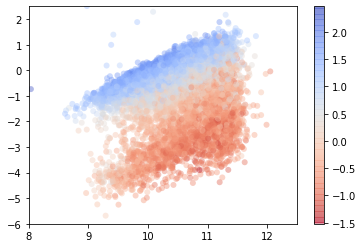

In [379]:
x=dataframe['log_Mass_no_corr']
y=dataframe['lSFR']
c=dataframe['EW_Ha_ALL'] 
x.to_numpy(dtype='float')
y.to_numpy(dtype='float')
c.to_numpy(dtype='float')
log_c=np.log10(np.abs(c))
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.4,edgecolor='none',cmap=cm)
axes.set_xlim([8,12.5])
axes.set_ylim([-6,2.5])
fig.colorbar(figure, ax=axes)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


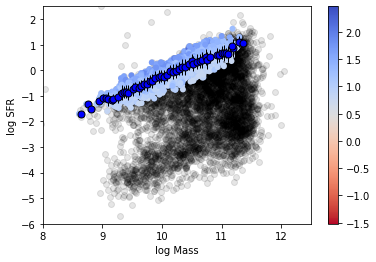

In [380]:
x=dataframe['log_Mass_no_corr']
y=dataframe['lSFR']
c=dataframe['EW_Ha_ALL'] 
x.to_numpy(dtype='float')
y.to_numpy(dtype='float')
c.to_numpy(dtype='float')
log_c=np.log10(np.abs(c))
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
# We add more restrictions:
# (1)  z<0.05  3544 -> 2917
# (2) Elip = sqrt(1-ab^2) 2917 -> 2166
# (3) T>1 => This is difficult to replicate, but we use the sersic index <2.5  2166 -> 1764
# (4) QC. I got for granted.
# (5) Number of spaxels... i use the 'frac_area_SFR_pure' parameter > 10%  1764 -> 1682 (enough points to make statistics!)
df_SFGs=dataframe[(dataframe['EW_Ha_ALL']>-10000) & (dataframe['EW_Ha_ALL']<-6) & ((dataframe['lSFR']-dataframe['log_Mass_no_corr'])<-9.5) & (np.isfinite(dataframe['OH_Re_fit_O3N2'])) & (dataframe['z_stars']<0.05) & (dataframe['nsa_sersic_ba']>0.35) & (dataframe['nsa_sersic_n']<2.5) & (dataframe['frac_area_SFR_pure']>0.1)]
#df_SFGs=dataframe[(dataframe['EW_Ha_ALL']>-10000) & (dataframe['EW_Ha_ALL']<-6) & ((dataframe['lSFR']-dataframe['log_Mass_no_corr'])<-9.5) & (np.isfinite(dataframe['OH_Re_fit_O3N2']))]
x_sf=df_SFGs['log_Mass_no_corr']
y_sf=df_SFGs['lSFR']
c_sf=df_SFGs['EW_Ha_ALL'] 
x_sf.to_numpy(dtype='float')
y_sf.to_numpy(dtype='float')
c_sf.to_numpy(dtype='float')
log_c_sf=np.log10(np.abs(c_sf))

figure=axes.scatter(x_sf, y_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=1,edgecolor='none',cmap=cm)

bin1 , min1 , max1= 0.05,8.5,11.5
m1, sM1, sD1 = binning(x_sf, y_sf, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.025, sM1, yerr= sD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )


axes.set_xlabel('log Mass')
axes.set_ylabel('log SFR')
axes.set_xlim([8,12.5])
axes.set_ylim([-6,2.5])
fig.colorbar(figure, ax=axes)

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR M* vs SFR = 0.87569380444423
CR M* vs Delta_SFR = -0.012907163563054045


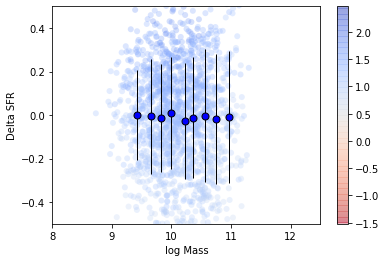

In [381]:
#
# We remove the dependence with the M*
#

#
# We start with the O/H dependence on the Mass
#

SFR_smooth=np.interp(x_sf,m1,sM1)
Delta_SFR=y_sf-SFR_smooth
#print(Delta_OH)
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(x_sf, Delta_SFR, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin1 , min1 , max1= 0.25,8.5,11.5
m1, dsM1, dsD1 = binning(x_sf, Delta_SFR, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.1, dsM1, yerr= dsD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('log Mass')
axes.set_ylabel('Delta SFR')
axes.set_xlim([8,12.5])
axes.set_ylim([-0.5,0.5])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(x_sf,y_sf)
print('CR M* vs SFR =',cr[0,1])
mask = (np.isfinite(x_sf)) & (np.isfinite(Delta_SFR))
cr=np.corrcoef(x_sf[mask],Delta_SFR[mask])
print('CR M* vs Delta_SFR =',cr[0,1])
#
# The correlation with M* disappears!
#

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


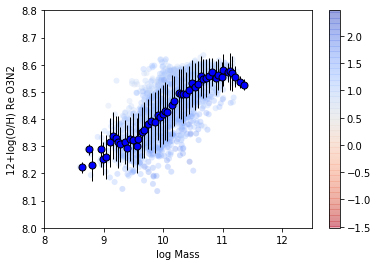

In [382]:
OH_sf=df_SFGs['OH_Re_fit_O3N2']
OH_sf.to_numpy(dtype='float')

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
figure=axes.scatter(x_sf, OH_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bin1 , min1 , max1= 0.05,8.5,11.5
m1, OHM1, OHD1 = binning(x_sf, OH_sf, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.025, OHM1, yerr= OHD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )

axes.set_xlabel('log Mass')
axes.set_ylabel('12+log(O/H) Re O3N2')
axes.set_xlim([8,12.5])
axes.set_ylim([8,8.8])
fig.colorbar(figure, ax=axes)



/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


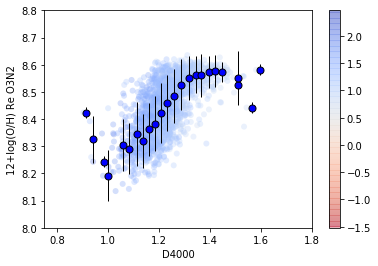

In [383]:
#
# D4000
#
D4000_sf=df_SFGs['D4000_Re_fit']
D4000_sf.to_numpy(dtype='float')
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
figure=axes.scatter(D4000_sf, OH_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bind , mind , maxd= 0.03,0.7,1.7
d, OH_d, OHD_d = binning(D4000_sf, OH_sf, bind , mind , maxd )
p1 = plt.errorbar(d+0.015, OH_d, yerr= OHD_d, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )

axes.set_xlabel('D4000')
axes.set_ylabel('12+log(O/H) Re O3N2')
axes.set_xlim([0.75,1.8])
axes.set_ylim([8,8.8])
fig.colorbar(figure, ax=axes)



/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR M* vs 12+log O/H = 0.7108460865135716
CR M* vs Delta_O/H = -0.09075739208732081


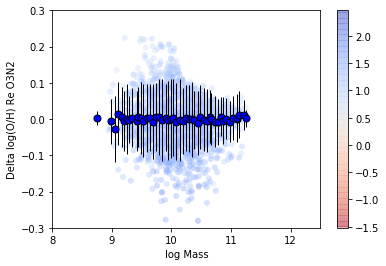

In [384]:
#
# You need to subtract the global trend (all) to describe possible secondary trends!
#

#
# We continue with the O/H dependence on the Mass
#

OH_smooth=np.interp(x_sf,m1,OHM1)
Delta_OH=OH_sf-OH_smooth
#print(Delta_OH)
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(x_sf, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin1 , min1 , max1= 0.05,8.5,11.5
m1, OHM1, OHD1 = binning(x_sf, Delta_OH, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.025, OHM1, yerr= OHD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('log Mass')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([8,12.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(x_sf,OH_sf)
print('CR M* vs 12+log O/H =',cr[0,1])
mask = (np.isfinite(x_sf)) & (np.isfinite(Delta_OH))
cr=np.corrcoef(x_sf[mask],Delta_OH[mask])
print('CR M* vs Delta_O/H =',cr[0,1])
#
# The correlation with M* disappears!
#

#
# If you see the mean points, there is residual trend with M*
#



/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR D4000 vs 12+log O/H = 0.5923956905143758
CR D4000 vs Delta_O/H = -0.12375927830286251


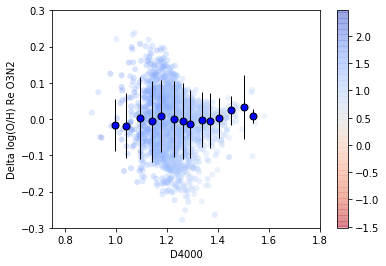

In [385]:
#
# You need to subtract the global trend (all) to describe possible secondary trends!
#

#
# We start with the O/H dependence on D4000
#

OH_smooth_D4000=np.interp(D4000_sf,d,OH_d)
Delta_OH_D4000=OH_sf-OH_smooth_D4000
#print(Delta_OH)
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(D4000_sf, Delta_OH_D4000, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bind , mind , maxd= 0.05,0.7,1.7
d, OH_d, OHD_d = binning(D4000_sf, Delta_OH_D4000, bind , mind , maxd )
p1d = plt.errorbar(d+0.025, OH_d, yerr= OHD_d, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('D4000')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([0.75,1.8])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(D4000_sf,OH_sf)
print('CR D4000 vs 12+log O/H =',cr[0,1])
mask_D4000 = (np.isfinite(D4000_sf)) & (np.isfinite(Delta_OH_D4000))
cr=np.corrcoef(D4000_sf[mask_D4000],Delta_OH_D4000[mask_D4000])
print('CR D4000 vs Delta_O/H =',cr[0,1])
#
# The correlation with M* disappears!
#

#
# If you see the mean points, there is residual trend with M*
#

In [386]:
#
# Note that the correlation of O/H with the M*  (0.73) is clearly stronger than
# the dependence with D4000 (0.59)
# the strongest dependece is between SFR and M* (0.87) in any case

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


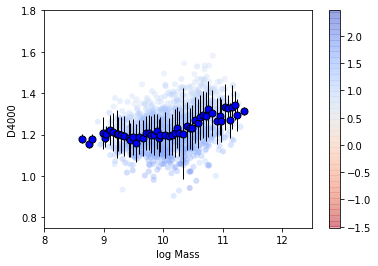

In [387]:
#
# Now we remove the dependence of D4000 with the Mass
#

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
figure=axes.scatter(x_sf, D4000_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bin1 , min1 , max1= 0.05,8.5,11.5
m1, D4M1, D4D1 = binning(x_sf, D4000_sf, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.025, D4M1, yerr= D4D1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )

axes.set_xlabel('log Mass')
axes.set_ylabel('D4000')
axes.set_xlim([8,12.5])
axes.set_ylim([0.75,1.8])
fig.colorbar(figure, ax=axes)


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR M* vs D4000 = 0.33339599616011456
CR M* vs Delta_D4000= -0.03691910996261858


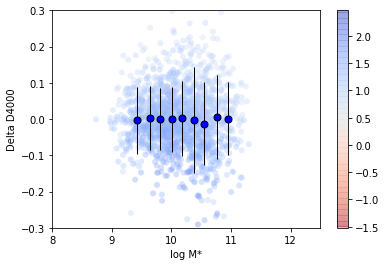

In [388]:
#
# We remove the dependence of D4000 with M*
#

smooth_D4000=np.interp(x_sf,m1,D4M1)
Delta_D4000=D4000_sf-smooth_D4000
#print(Delta_OH)
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(x_sf, Delta_D4000, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin1 , min1 , max1= 0.25,8.5,11.5
m1, dD4M1, dD4D1 = binning(x_sf, Delta_D4000, bin1 , min1 , max1 )
p1d = plt.errorbar(m1+0.125, dD4M1, yerr= dD4D1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
axes.set_xlabel('log M*')
axes.set_ylabel('Delta D4000')
axes.set_xlim([8,12.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(x_sf,D4000_sf)
print('CR M* vs D4000 =',cr[0,1])
mask_D4000 = (np.isfinite(x_sf)) & (np.isfinite(Delta_D4000))
cr=np.corrcoef(x_sf[mask_D4000],Delta_D4000[mask_D4000])
print('CR M* vs Delta_D4000=',cr[0,1])
#
# The correlation with M* disappears!
#


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR Delta_D4000 vs  Delta_OH= 0.5428401130797701
Coeffs lin fit Delta_D4000 vs. Delta_O/H= -0.04 0.012 0.024 0.041
The correlation has a trend of 0.54 dex/Delta_SFR. Thus, a clear effect


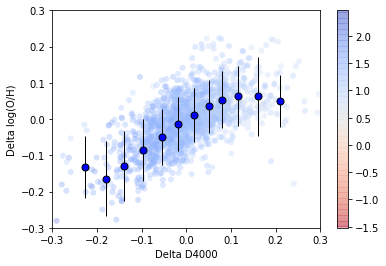

In [389]:
#
# Note that the correlation between D4000 and M* is the weaker of the three!
# 0.73 -> 0.59 -> 0.33
# Thus, maybe it is induced by the other two.

#
# Now that we remove the dependence with the Mass of both O/H and D4000 (residual correlation ~0.1)
# which correlation remains betwee the two?

#
# We remove the dependence of D4000 with M*
#

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter( Delta_D4000, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bin,min,max = 0.05,-0.5,0.5
X, Y, eY = binning(Delta_D4000, Delta_OH, bin, min, max)
p1d = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
#bin1 , min1 , max1= 0.25,8.5,11.5
#m1, dD4M1, dD4D1 = binning(x_sf, Delta_D4000, bin1 , min1 , max1 )
#p1d = plt.errorbar(m1+0.125, dD4M1, yerr= dD4D1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
axes.set_xlabel('Delta D4000')
axes.set_ylabel('Delta log(O/H)')
axes.set_xlim([-0.3,0.3])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
mask_D4000 = (np.isfinite(x_sf)) & (np.isfinite(Delta_D4000)) & (np.isfinite(Delta_OH))
cr=np.corrcoef(Delta_D4000[mask_D4000],Delta_OH[mask_D4000])
print('CR Delta_D4000 vs  Delta_OH=',cr[0,1])
#
# The correlation with M* disappears!
#
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask=np.isfinite(X) & np.isfinite(Y) & np.isfinite(eY)
#print(s2[mask_OHM2], OHM2[mask_OHM2])
pa1, ea1  = optimize.curve_fit(funct3, X[mask], Y[mask], sigma=eY[mask], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_D4000 vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))

print("The correlation has a trend of 0.54 dex/Delta_SFR. Thus, a clear effect")




CR Delta_SFR vs  Delta_OH= -0.3079199948128113
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.006 0.003 -0.095 0.011
The correlation has a trend of ~-0.10 dex/Delta_SFR, very, very weak!
The residual is not decreases significantly, as we claimed repeatly!!
Based on this results, I think the real secondary trend is  with D4000. The Delta_SFR is induced by this one!!!


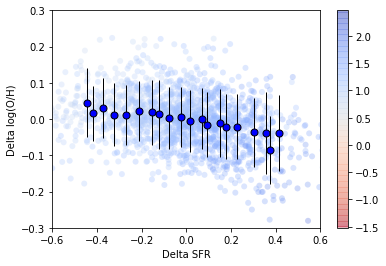

In [390]:
#
# And a secondary relation with the SFR?
#
#

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter( Delta_SFR, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin,min,max = 0.05,-0.5,0.5
X, Y, eY = binning(Delta_SFR, Delta_OH, bin, min, max)
p1d = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
#bin1 , min1 , max1= 0.25,8.5,11.5
#m1, dD4M1, dD4D1 = binning(x_sf, Delta_D4000, bin1 , min1 , max1 )
#p1d = plt.errorbar(m1+0.125, dD4M1, yerr= dD4D1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
axes.set_xlabel('Delta SFR')
axes.set_ylabel('Delta log(O/H)')
axes.set_xlim([-0.6,0.6])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
mask_D4000 = (np.isfinite(x_sf)) & (np.isfinite(Delta_D4000)) & (np.isfinite(Delta_OH)) & (np.isfinite(Delta_SFR))
cr=np.corrcoef(Delta_SFR[mask_D4000],Delta_OH[mask_D4000])
print('CR Delta_SFR vs  Delta_OH=',cr[0,1])
#
# If any, there is a weak trend! Far far weaker than the one described for  D4000
#

#
# Looking at the figure, only galaxies with high SFR present maybe a weak effect
#
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask=np.isfinite(X) & np.isfinite(Y) & np.isfinite(eY)
#print(s2[mask_OHM2], OHM2[mask_OHM2])
pa1, ea1  = optimize.curve_fit(funct3, X[mask], Y[mask], sigma=eY[mask], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))

print("The correlation has a trend of ~-0.10 dex/Delta_SFR, very, very weak!")
print("The residual is not decreases significantly, as we claimed repeatly!!")
print("Based on this results, I think the real secondary trend is  with D4000. The Delta_SFR is induced by this one!!!");


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR Delta_SFR vs  Delta_D4000= -0.3079199948128113
Coeffs lin fit Delta_SFR vs. Delta_D4000= -0.004 0.003 -0.231 0.01
The correlation is stronger than the one with O/H, and the slope too! 
Based on this results, I think the real secondary trend is  with D4000. The Delta_SFR is induced by this one!!!


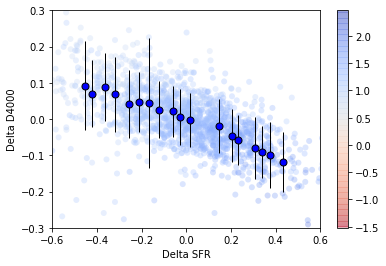

In [392]:
#
# And a secondary relation with the SFR?
#
#

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter( Delta_SFR, Delta_D4000, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin,min,max = 0.05,-0.5,0.5
X, Y, eY = binning(Delta_SFR, Delta_D4000, bin, min, max)
p1d = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
#bin1 , min1 , max1= 0.25,8.5,11.5
#m1, dD4M1, dD4D1 = binning(x_sf, Delta_D4000, bin1 , min1 , max1 )
#p1d = plt.errorbar(m1+0.125, dD4M1, yerr= dD4D1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
axes.set_xlabel('Delta SFR')
axes.set_ylabel('Delta D4000')
axes.set_xlim([-0.6,0.6])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
mask_D4000 = (np.isfinite(x_sf)) & (np.isfinite(Delta_D4000)) & (np.isfinite(Delta_OH)) & (np.isfinite(Delta_SFR))
cr=np.corrcoef(Delta_SFR[mask_D4000],Delta_OH[mask_D4000])
print('CR Delta_SFR vs  Delta_D4000=',cr[0,1])
#
# If any, there is a weak trend! Far far weaker than the one described for  D4000
#

#
# Looking at the figure, only galaxies with high SFR present maybe a weak effect
#
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask=np.isfinite(X) & np.isfinite(Y) & np.isfinite(eY)
#print(s2[mask_OHM2], OHM2[mask_OHM2])
pa1, ea1  = optimize.curve_fit(funct3, X[mask], Y[mask], sigma=eY[mask], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_D4000=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))

print("The correlation is stronger than the one with O/H, and the slope too! ")
print("Based on this results, I think the real secondary trend is  with D4000. The Delta_SFR is induced by this one!!!");


In [393]:
#
# Thus, there is secondary relation with D4000 that does not
# depends on the M*!!!
#
# However, the possible se
# 

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


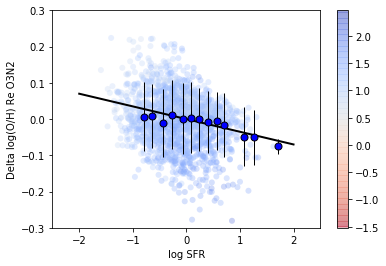

In [394]:
#
# Is there a secondary trend with the SFR?
#
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(y_sf, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin2 , min2 , max2= 0.2,-2.5,2.5
s2, OHM2, OHD2 = binning(y_sf, Delta_OH, bin2 , min2 , max2 )
p1 = plt.errorbar(s2+0.1, OHM2, yerr= OHD2, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
funct3    = lambda x,a,b: a + b * x
s_plot=np.linspace(-2, 2, 10)
y_plot=funct3(s_plot,0,-0.035)

f1 = plt.plot(s_plot, y_plot, '-k', linewidth = 2, markerfacecolor ='black'  , color ='black' )

axes.set_xlabel('log SFR')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([-2.5,2.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#




In [395]:
#
# There is correlation between the residuals?
#



In [396]:

#
# Now, which is the correlation coefficient?
#

cr=np.corrcoef(y_sf,OH_sf)
print('CR SFR vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(y_sf,Delta_OH)
print('CR SFR vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask_OHM2=np.isfinite(OHM2) & np.isfinite(s2) & np.isfinite(OHD2)
#print(s2[mask_OHM2], OHM2[mask_OHM2])
pa1, ea1  = optimize.curve_fit(funct3, s2[mask_OHM2], OHM2[mask_OHM2], sigma=OHD2[mask_OHM2], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
#print (pa1)
#
# The correlation with betwen Delta-O/H (residual of the MZR) and the SFR is very very weak!
#


#
# We substract the SFMS:
#
m3, SFR3, e_SFR3 = binning(x_sf, y_sf, bin1 , min1 , max1 )
SFMS_smooth=np.interp(x_sf,m3,SFR3)
Delta_SFMS=y_sf-SFMS_smooth
cr=np.corrcoef(Delta_SFMS,Delta_OH)
print('CR Delta_SFR vs Delta log O/H =',cr[0,1])
bin3,min3,max3=0.15,-0.5,0.5
DSFR4, DOH4, e_DOH4 = binning( Delta_SFMS, Delta_OH,bin3 , min3 , max3 )
mask_3=np.isfinite(DSFR4) & np.isfinite(DOH4) & np.isfinite(e_DOH4)
pa1, ea1  = optimize.curve_fit(funct3, DSFR4[mask_3], DOH4[mask_3], sigma=e_DOH4[mask_3], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, DSFR4[mask_3], DOH4[mask_3], p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
print('The slope of the possible secondary relation is almost ZERO. Far from the FMR (0.32)')
print('The implementation would not change the residual at all!')
#
# The secondary trend, if any is very very weak!
#

#
# The slope of the secondary correlation is very very weak!!!!
# of the order of the ZERO!!!!!

#
# In summary, there is no general secondary correlation
#




CR SFR vs 12+log O/H = 0.5181176570664937
CR SFR vs Delta log O/H = nan
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.009 0.004 -0.04 0.003
CR Delta_SFR vs Delta log O/H = nan
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.012 0.007 -0.13 0.029
The slope of the possible secondary relation is almost ZERO. Far from the FMR (0.32)
The implementation would not change the residual at all!


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [397]:
#
# I select now a range between 9.2 y 9.6
#


#
# Now, which is the correlation coefficient?
#

mask_Mass= (x_sf>=9.2) & (x_sf<9.6)
print('9.2 < log M* < 9.6')
cr=np.corrcoef(y_sf[mask_Mass],OH_sf[mask_Mass])
print('CR SFR vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(y_sf[mask_Mass],Delta_OH[mask_Mass])
print('CR SFR vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[1,1]
s2, OHM2, OHD2 = binning(y_sf[mask_Mass], Delta_OH[mask_Mass], bin2 , min2 , max2 )
mask_OHM2=np.isfinite(OHD2) & np.isfinite(s2) & np.isfinite(OHD2)
pa1, ea1  = optimize.curve_fit(funct3, s2[mask_OHM2], OHM2[mask_OHM2], sigma=OHD2[mask_OHM2], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
print (pa1)
#
# The correlation with betwen Delta-O/H (residual of the MZR) and the SFR is very very weak!
#

#
# We substract the SFMS:
#
m3, SFR3, e_SFR3 = binning(x_sf, y_sf, bin1 , min1 , max1 )
SFMS_smooth=np.interp(x_sf,m3,SFR3)
Delta_SFMS=y_sf-SFMS_smooth
cr=np.corrcoef(Delta_SFMS,Delta_OH)
print('CR Delta_SFR vs Delta log O/H =',cr[0,1])
bin3,min3,max3=0.15,-0.5,0.5
DSFR4, DOH4, e_DOH4 = binning( Delta_SFMS, Delta_OH,bin3 , min3 , max3 )
mask_3=np.isfinite(DSFR4) & np.isfinite(DOH4) & np.isfinite(e_DOH4)
pa1, ea1  = optimize.curve_fit(funct3, DSFR4[mask_3], DOH4[mask_3], sigma=e_DOH4[mask_3], p0 = START )
#print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
print('In this range, the slope is -0.127, far from the FMR, but as we published, only at low-M* is there')
print('a possible effect. But again, far from the reduction of the RMS described in Manucci et al. 2010 0.1->0.05 dex')
print('This relation does not reduce significantly the residual... so, there is no need to incllude it')
#
# The secondary trend, if any is very very weak!
#

#
# The slope of the secondary correlation is very very weak!!!!
# of the order of the ZERO!!!!!

#
# In summary, there is no general secondary correlation
#

9.2 < log M* < 9.6
CR SFR vs 12+log O/H = -0.3899084247969159
CR SFR vs Delta log O/H = -0.4073602249543678
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.111 0.006 -0.143 0.008
[-0.11091632 -0.14273777]
CR Delta_SFR vs Delta log O/H = nan


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.012 0.007 -0.13 0.029
In this range, the slope is -0.127, far from the FMR, but as we published, only at low-M* is there
a possible effect. But again, far from the reduction of the RMS described in Manucci et al. 2010 0.1->0.05 dex
This relation does not reduce significantly the residual... so, there is no need to incllude it


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR M* vs Mgas = 0.8606658748083886
The correlation is pretty strong
stddev of Mgas around the mean trend =  0.258024175371112
stddev of M* around the mean trend =  0.27611449923859444
The dispersion in both axis is pretty similar
Thus: Despite of the nominal error, the real error is very very very similar!!!!


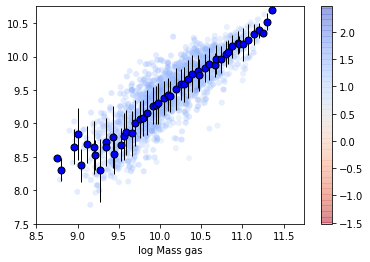

In [398]:
#
# Now we see if there is a secondary relation with Mgas
#
c_gas_sf=df_SFGs['log_Mass_gas'] 
c_gas_sf.to_numpy(dtype='float')

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
figure=axes.scatter(x_sf, c_gas_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bin1 , min1 , max1= 0.05,8.5,11.5
m1, gM1, gD1 = binning(x_sf, c_gas_sf, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.025, gM1, yerr= gD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )

axes.set_xlabel('log Mass stars')
axes.set_xlabel('log Mass gas')
axes.set_xlim([8.5,11.75])
axes.set_ylim([7.5,10.75])

fig.colorbar(figure, ax=axes)

cr=np.corrcoef(x_sf,c_gas_sf)
print('CR M* vs Mgas =',cr[0,1])
print('The correlation is pretty strong')


smooth_Mgas=np.interp(x_sf,m1,gM1)
Delta_Mgas=c_gas_sf-smooth_Mgas

smooth_M=np.interp(c_gas_sf,gM1,m1)
Delta_M=x_sf-smooth_M

sig_gas=np.std(Delta_Mgas)
sig_stars=np.std(Delta_M)

print("stddev of Mgas around the mean trend = ",sig_gas)
print("stddev of M* around the mean trend = ",sig_stars)
print('The dispersion in both axis is pretty similar');
print('Thus: Despite of the nominal error, the real error is very very very similar!!!!');

CR Delta_Mgas vs  Delta_OH= 0.028495787467943443
Coeffs lin fit Delta_SFR vs. Delta_O/H= -0.002 0.003 -0.02 0.01
The correlation has a trend of ~-0.10 dex/Delta_SFR, very, very weak!
The residual is not decreases significantly, as we claimed repeatly!!
Based on this results, I think the real secondary trend is  with D4000. The Delta_SFR is induced by this one!!!


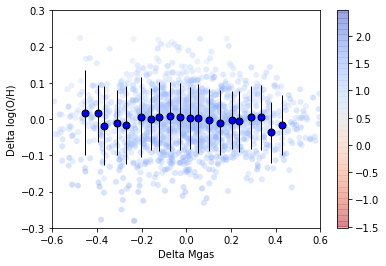

In [399]:
#
# And a secondary relation with the SFR?
#
#

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter( Delta_Mgas, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin,min,max = 0.05,-0.5,0.5
X, Y, eY = binning(Delta_Mgas, Delta_OH, bin, min, max)
p1d = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
#bin1 , min1 , max1= 0.25,8.5,11.5
#m1, dD4M1, dD4D1 = binning(x_sf, Delta_D4000, bin1 , min1 , max1 )
#p1d = plt.errorbar(m1+0.125, dD4M1, yerr= dD4D1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'D4000' )
axes.set_xlabel('Delta Mgas')
axes.set_ylabel('Delta log(O/H)')
axes.set_xlim([-0.6,0.6])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
#
# If dependence is well removed, then there should be no secondary correlation
#
mask = (np.isfinite(c_gas_sf)) & (np.isfinite(Delta_Mgas)) & (np.isfinite(Delta_OH)) & (np.isfinite(Delta_SFR))
cr=np.corrcoef(Delta_Mgas[mask],Delta_OH[mask])
print('CR Delta_Mgas vs  Delta_OH=',cr[0,1])
#
# If any, there is a weak trend! Far far weaker than the one described for  D4000
#

#
# Looking at the figure, only galaxies with high SFR present maybe a weak effect
#
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask=np.isfinite(X) & np.isfinite(Y) & np.isfinite(eY)
#print(s2[mask_OHM2], OHM2[mask_OHM2])
pa1, ea1  = optimize.curve_fit(funct3, X[mask], Y[mask], sigma=eY[mask], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))

print("The correlation has a trend of ~-0.10 dex/Delta_SFR, very, very weak!")
print("The residual is not decreases significantly, as we claimed repeatly!!")
print("Based on this results, I think the real secondary trend is  with D4000. The Delta_SFR is induced by this one!!!");


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


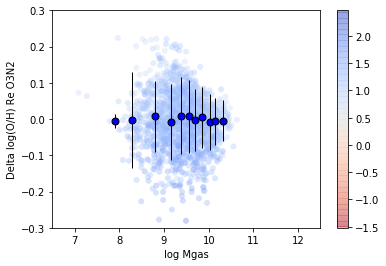

In [400]:
#
# Is there a secondary trend with the SFR?
#
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(c_gas_sf, Delta_OH, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
bin4 , min4 , max4= 0.2,7.5,11.5
mgas4, OHM4, OHD4 = binning(c_gas_sf, Delta_OH, bin4 , min4 , max4 )
p1 = plt.errorbar(mgas4+0.1, OHM4, yerr= OHD4, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('log Mgas')
axes.set_ylabel('Delta log(O/H) Re O3N2')
axes.set_xlim([6.5,12.5])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)

#print (pa1)

#
# There is no secondary relation with Mgas, even less than with SFR. The correlation is two weak with very low slope!
#

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CR Mgas vs 12+log O/H = 0.6225445928923625
CR Mgas vs Delta log O/H = nan
Coeffs lin fit Delta_Mgas vs. Delta_O/H= -0.015 0.012 0.001 0.001
There is no secondary relation with Mgas!!!


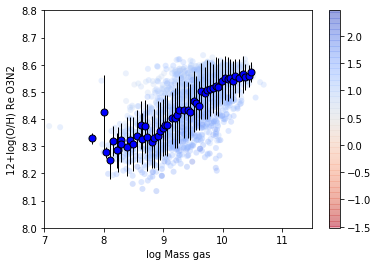

In [401]:

fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
#figure_back=axes.scatter(x, y,  alpha=0.1, color='black')
#figure=axes.scatter(x, y, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.1,edgecolor='none',cmap=cm)
figure=axes.scatter(c_gas_sf, OH_sf, c=log_c_sf, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)

bin1 , min1 , max1= 0.05,7.5,10.5
m1, OHM1, OHD1 = binning(c_gas_sf, OH_sf, bin1 , min1 , max1 )
p1 = plt.errorbar(m1+0.025, OHM1, yerr= OHD1, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )

axes.set_xlabel('log Mass gas')
axes.set_ylabel('12+log(O/H) Re O3N2')
axes.set_xlim([7,11.5])
axes.set_ylim([8,8.8])
fig.colorbar(figure, ax=axes)



#
# If dependence is well removed, then there should be no secondary correlation
#
cr=np.corrcoef(c_gas_sf,OH_sf)
print('CR Mgas vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(c_gas_sf,Delta_OH)
print('CR Mgas vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[0.1,0.1]
mask_OHM4=np.isfinite(OHM4) & np.isfinite(mgas4) & np.isfinite(OHD4)
pa1, ea1  = optimize.curve_fit(funct3, mgas4[mask_OHM4], OHM4[mask_OHM4], sigma=OHD4[mask_OHM4], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_Mgas vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))

print ("There is no secondary relation with Mgas!!!")

#print('Coeffs lin fit Mgas vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))

In [402]:
#
# Now for the range of masses 9.2-9.6
#
print('Relation of Mgas and O/H and Delta_O/H')
print('9.2 < Log M* < 9.6')
cr=np.corrcoef(c_gas_sf[mask_Mass],OH_sf[mask_Mass])
print('CR Mgas vs 12+log O/H =',cr[0,1])
cr=np.corrcoef(c_gas_sf[mask_Mass],Delta_OH[mask_Mass])
print('CR Mgas vs Delta log O/H =',cr[0,1])
funct3    = lambda x,a,b: a + b * x
START=[1,1]
mgas4, OHM4, OHD4 = binning(c_gas_sf[mask_Mass], Delta_OH[mask_Mass], bin4 , min4 , max4 )
mask_OHM4=np.isfinite(OHM4) & np.isfinite(mgas4) & np.isfinite(OHD4)
pa1, ea1  = optimize.curve_fit(funct3, mgas4[mask_OHM4], OHM4[mask_OHM4], sigma=OHD4[mask_OHM4], p0 = START )
#pa1, ea1  = optimize.curve_fit(funct3, s2, OHM2, sigma=0.1, p0 = START )
print('Coeffs lin fit Delta_SFR vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
#print('Coeffs lin fit Mgas vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3))
print('So, the slope of the relation is 0.476, but the correlation coeff. is near ZERO!')
#
# The correlation coefficent indicate that there is no secondary relation!
#

Relation of Mgas and O/H and Delta_O/H
9.2 < Log M* < 9.6
CR Mgas vs 12+log O/H = -0.04572938811239064
CR Mgas vs Delta log O/H = -0.0673776346811675
Coeffs lin fit Delta_SFR vs. Delta_O/H= 0.031 0.779 -0.003 0.082
So, the slope of the relation is 0.476, but the correlation coeff. is near ZERO!


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [403]:
#
# The following are tests
#  I recommend to remove the outlyiers from the 1st distribution
# for doing so, I derive the density, and I would remove the points that are 95% out  of the distribution
# but I have not finished that!

CR Mgas vs O/H [9.2,9.6]= [[ 1.         -0.04572939]
 [-0.04572939  1.        ]]


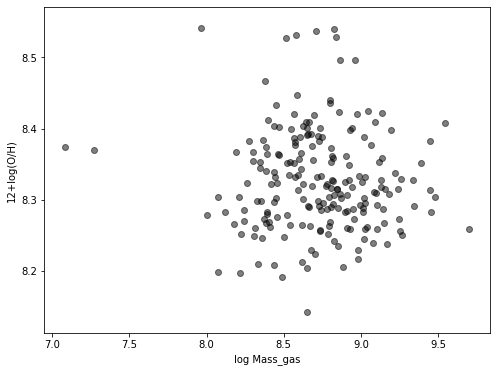

In [336]:
#
# Now a select the galaxies within the mass range between 9.2 and 9.6
#
mask= (x_sf>=9.2) & (x_sf<9.6)
x_mask=x_sf[mask]
y_mask=y_sf[mask]
OH_mask=OH_sf[mask]
m_gas_mask=c_gas_sf[mask]

fig, axes = plt.subplots(figsize=(8,6))
cm = plt.cm.get_cmap('magma')
figure=axes.scatter(m_gas_mask, OH_mask, alpha=0.5, color='black') #c=c_gas_sf, vmin=6.8,vmax=11.2,edgecolor='none',cmap=cm)
axes.set_xlabel('log Mass_gas')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([6,11])
axes.set_ylim([ymin,ymax])
axes.axis('tight')
cr=np.corrcoef(m_gas_mask,OH_mask)
print('CR Mgas vs O/H [9.2,9.6]=',cr)


CR Mgas vs O/H = [[1.         0.62254459]
 [0.62254459 1.        ]]


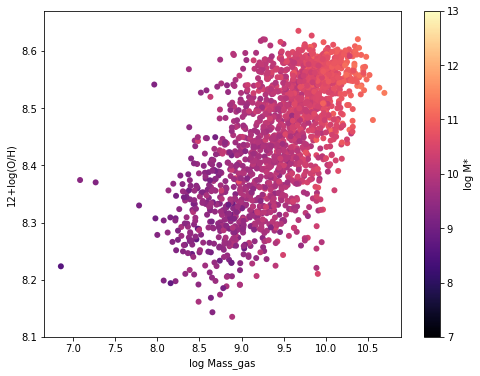

In [405]:
#
# Now a select the galaxies within the mass range between 9.2 and 9.6
#
fig, axes = plt.subplots(figsize=(8,6))
cm = plt.cm.get_cmap('magma')
figure=axes.scatter(c_gas_sf, OH_sf, c=x_sf, vmin=7,vmax=13,edgecolor='none',cmap=cm)
axes.set_xlabel('log Mass_gas')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([6,11])
axes.set_ylim([ymin,ymax])
fig.colorbar(figure, ax=axes, label='log M*')
axes.axis('tight')
cr=np.corrcoef(c_gas_sf,OH_sf)
print('CR Mgas vs O/H =',cr)